In [1]:
import gzip
import os
import pickle
import tarfile
from typing import Dict, List

import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from dgl.data import DGLDataset
from dgl.data.utils import download as dgl_download
from dgl.data.utils import load_graphs, save_graphs
from dgl.sampling import global_uniform_negative_sampling
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

# Graph Machine Learning by Hand

The old-school method of machine learning that was common practice before graph embeddings and Graph Neural Networks was to hand engineer features of the nodes of a network by querying the network with `networkx` or a graph database like Neo4j using Cypher or Gremlin and to assign the results of those queries to nodes.

What are some common features when hand engineering node features in graph machine learning tasks?

## Hand Engineered Features in Graph ML

* Scalable Centralities: Degree [in, out, total], Eigenvector, PageRank [a form of eigenvector centrality], Katz
* Less Scalable Centralities: Closeness, Betweenness

You can compute these methods on single edges or on multiple edges as a way of projecting a _higher-order_ network, a network composed of more complex semantics built from the base network. Graph ML worked this way until around 2015, when graph embeddings changed everything :)

## Loading our Citation Graph

In Part 1 on knowledge graph construction, we saved our graph in GEXF format. Let's load it using the same procedure we performed in Part 2. I'm going to abbreviate the comments here, look at Part 2 for more details on what I am doing.

In [2]:
G: nx.DiGraph = nx.read_gexf(path="data/physics_labeled.gexf.gz")

In [3]:
G.number_of_nodes(), G.number_of_edges()

(27770, 352807)

In [4]:
with open("data/citation/file_to_net.pkl", "rb") as f:
    file_to_net = pickle.load(f)

# Everything ok? Yes!
list(file_to_net.items())[0:10]

[(1001, 0),
 (9304045, 1),
 (9308122, 2),
 (9309097, 3),
 (9311042, 4),
 (9401139, 5),
 (9404151, 6),
 (9407087, 7),
 (9408099, 8),
 (9501030, 9)]

In [5]:
with open("data/citation/net_to_file.pkl", "rb") as f:
    net_to_file = pickle.load(f)

# Everything ok here too? Yes!
list(net_to_file.items())[0:10]

[(0, 1001),
 (1, 9304045),
 (2, 9308122),
 (3, 9309097),
 (4, 9311042),
 (5, 9401139),
 (6, 9404151),
 (7, 9407087),
 (8, 9408099),
 (9, 9501030)]

In [6]:
def convert_ids_to_int(G):
    # Create a new directed graph
    G_int = nx.DiGraph()
    
    # Create a mapping from string IDs to integer IDs
    id_mapping = {str_id: int(str_id) for str_id in G.nodes()}
    
    # Copy nodes and attributes, converting IDs to integers
    for str_id, data in G.nodes(data=True):
        int_id = id_mapping[str_id]
        G_int.add_node(int_id, **data)
    
    # Copy edges and attributes, converting IDs to integers
    for str_id1, str_id2, data in G.edges(data=True):
        int_id1, int_id2 = id_mapping[str_id1], id_mapping[str_id2]
        G_int.add_edge(int_id1, int_id2, **data)
    
    return G_int

# Convert G to use integer IDs
G_int = convert_ids_to_int(G)

In [7]:
G_int.number_of_nodes(), G_int.number_of_edges()

(27770, 352807)

In [8]:
# Let's test or integer index now... we pickled it instead of JSONized it so it would retain its integer keys and values!
test_id = file_to_net[9711194]
G_int.nodes[test_id]

{'file_id': 9711194,
 'sequential_id': 5886,
 'Paper': 'hep-th/9711194',
 'Date': 'Wed, 26 Nov 1997 20:26:20 GMT',
 'Title': 'On Integrable Structure behind the Generalized WDVV Equations',
 'Comments': 'LaTeX, 6pp',
 'Report-no': 'ITEP/TH-67/97',
 'Journal-ref': 'Phys.Lett. B427 (1998) 93-96',
 'Abstract': 'In the theory of quantum cohomologies the WDVV equations imply integrability of the system $(I\\partial_\\mu - zC_\\mu)\\psi = 0$. However, in generic situation -- of which an example is provided by the Seiberg-Witten theory -- there is no distinguished direction (like $t^0$) in the moduli space, and such equations for $\\psi$ appear inconsistent. Instead they are substituted by $(C_\\mu\\partial_\\nu - C_\\nu\\partial_\\mu)\\psi^{(\\mu)} \\sim (F_\\mu\\partial_\\nu - F_\\nu\\partial_\\mu)\\psi^{(\\mu)} = 0$, where matrices $(F_\\mu)_{\\alpha\\beta} = \\partial_\\alpha \\partial_\\beta \\partial_\\mu F$.',
 'Journal-ref-DBSCAN': 2,
 'Journal-ref-Label': 'Phys.Lett.',
 'label': '588

### `G_int` --> `G`

Now we can assign our new integer graph back to `G` and use it below :)

In [9]:
G = G_int

## Feature Engineering for Link Prediction

Remember this slide? Think on it again :) We are going to implement a couple of these to drive our first Journal classifier :)

<center><img src="images/Feature-Engineering-for-Link-Prediction.jpg" width="1000px" /></center>

We are going to load our citation graph and then combine the text embeddings we prepared before with manually computed features to perform link prediction. We will see how our metrics affect performance. Try not to jump to using an embedding, this is a useful exercise and we always need baselines :)

Our job is to prepare a network features vector `features` that we can append to our other features before we train a classifier to perform link prediction.

### Store Features by Column in `features`

We will compute features for each node or pairs of nodes and then store them in the `features` `np.ndarray` by appending one column at a time. One row is a node. This is described in [NumPy: How to add an extra column to a NumPy array](https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-86.php) as looking like:

<center><img src="images/append-column-to-matrix.png" width="500px" /></center>

#### Re-Running Feature Appends Will Make Duplicate Feature Columns

Warning: If you run the cells below that do `np.append(features, my_feat_ary, axis=1)` more than once... you will get a duplicate features column.

In [10]:
# I had to look this up, so here you are :)
import numpy as np
x = np.array([[10,20,30], [40,50,60]])
y = np.array([[100], [200]])
x, y, np.append(x, y, axis=1)

(array([[10, 20, 30],
        [40, 50, 60]]),
 array([[100],
        [200]]),
 array([[ 10,  20,  30, 100],
        [ 40,  50,  60, 200]]))

### Initialize `features` `nd.array`

You can re-run this to recalculate the features from scratch.

In [11]:
# Create an inner list for each node ID
inner_lists = [[] for x in range(G.number_of_nodes())]

# The shape is 27,770 nodes long with zero feature columns
features = np.array(inner_lists)
features

array([], shape=(27770, 0), dtype=float64)

### `networkx` Centrality Metrics

For our first features, we will use `networkx` to compute some centrality metrics. I'm going to limit our calculations to two centralities you can use in practice on networks of most any size:

* Degree Centrality (in degree, out degree, degree [both]) - this is simple and shows how well connected a node is
* Eigenvector Centrality - measures the influence of a node in a network, where a node is considered influential if it is connected to other influential nodes.

Check out this list of [networkx.centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) metrics for feature ideas.

#### Display Metrics using `pd.Series`

If you want to see a metric computer by `nx.my_function()` you can wrap the `Dict` it returns [which will ALL print in a notebok] in a `pd.Series` and it will use the node ID as the index and display the feature. It is a good idea to lay eyes on things you compute - when possible - as often something goes wrong on a first attempt :)

#### Degree Centrality

Degree centrality is a **local centrality** metric. It measure influence in the nearby network.

NetworkX measures degree centrality as a relative value for all nodes in a network. This can complicate inference but keeps values within an interpretable range.

In [12]:
degree = nx.degree_centrality(G)

# See - takes just 11 lines. The Dict printed over 27K rows on my screen. Try it!
pd.Series(degree)

0        0.003349
1        0.000612
2        0.004393
3        0.005186
4        0.002053
           ...   
27765    0.000036
27766    0.000216
27767    0.000216
27768    0.000036
27769    0.000288
Length: 27770, dtype: float64

In [13]:
in_degree = nx.in_degree_centrality(G)
pd.Series(in_degree)

0        0.000360
1        0.000576
2        0.004141
3        0.005042
4        0.001981
           ...   
27765    0.000036
27766    0.000000
27767    0.000000
27768    0.000000
27769    0.000000
Length: 27770, dtype: float64

In [14]:
out_degree = nx.out_degree_centrality(G)
pd.Series(out_degree)

0        0.002989
1        0.000036
2        0.000252
3        0.000144
4        0.000072
           ...   
27765    0.000000
27766    0.000216
27767    0.000216
27768    0.000036
27769    0.000288
Length: 27770, dtype: float64

In [15]:
# Prepare and append the degree features for addition to `features`
for d in [degree, in_degree, out_degree]:
    d_ary = np.array(list(d.values())).reshape(-1, 1)
    features = np.append(features, d_ary, axis=1)

features

array([[3.34905830e-03, 3.60113796e-04, 2.98894451e-03],
       [6.12193453e-04, 5.76182074e-04, 3.60113796e-05],
       [4.39338831e-03, 4.14130865e-03, 2.52079657e-04],
       ...,
       [2.16068278e-04, 0.00000000e+00, 2.16068278e-04],
       [3.60113796e-05, 0.00000000e+00, 3.60113796e-05],
       [2.88091037e-04, 0.00000000e+00, 2.88091037e-04]])

#### Eigenvector Centrality

Eigenvector centrality is a **global centrality** metric. It measures influence within the entire network. _We always want a local and global centrality metric in our feature set_.

In [16]:
eigenvector = nx.eigenvector_centrality_numpy(G)
pd.Series(eigenvector)

0        9.470787e-10
1        1.349713e-03
2        1.930384e-02
3        2.848440e-02
4        6.179491e-03
             ...     
27765   -7.427965e-20
27766   -7.142436e-21
27767    1.746771e-20
27768   -1.008322e-20
27769    5.738300e-21
Length: 27770, dtype: float64

#### Wrapping Centralities

That gives us three features so far that indicate a node's prominence in the network. What about other factors?

In [17]:
features, features.shape

(array([[3.34905830e-03, 3.60113796e-04, 2.98894451e-03],
        [6.12193453e-04, 5.76182074e-04, 3.60113796e-05],
        [4.39338831e-03, 4.14130865e-03, 2.52079657e-04],
        ...,
        [2.16068278e-04, 0.00000000e+00, 2.16068278e-04],
        [3.60113796e-05, 0.00000000e+00, 3.60113796e-05],
        [2.88091037e-04, 0.00000000e+00, 2.88091037e-04]]),
 (27770, 3))

### Community Detection

One thing we didn't cover in Part 2 - Network Science, was community detection. What community a node belongs to is an important feature. We're going to cluster our network into communities and visualize them in Graphistry. Then we're going to add the cluster IDs as features in our `features` `np.array`.

#### Louvain Modularity

The most common method of community detection is [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_method). We're going to use [nx.community.louvain_communities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities) because it is efficient. You can usually find a Louvain Modularity implementation for whatever platform you use to process even large networks - big data.

> The method is a greedy optimization method that appears to run in time `O(n * log(n))`.
>
> ...
> 
> In the Louvain Method of community detection, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and the first step is repeated.

-- Wikipedia, [Louvain method](https://en.wikipedia.org/wiki/Louvain_method)

In [18]:
clusters = nx.community.louvain_communities(G, seed=31337)
len(clusters)

1512

#### Evaluating Modularity

I am curious how many clusters there are... lets plot their size in Seaborn using log scale. You can see there is a power law distribtion in cluster size.

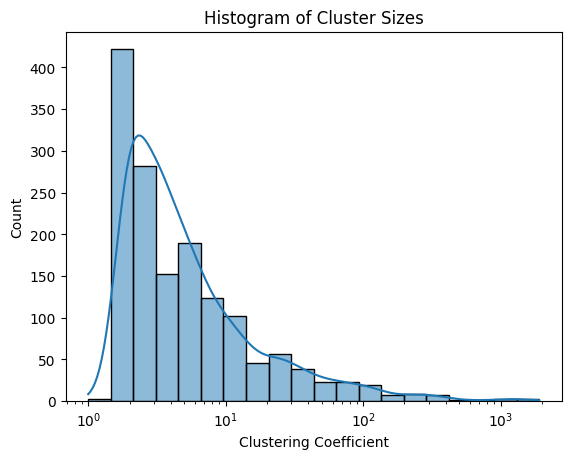

In [19]:
# Get connected components and their sizes
cluster_size = [len(c) for c in clusters]

# Use seaborn to create the histogram
sns.histplot(cluster_size, kde=True, bins=20, log_scale=True)
plt.title("Histogram of Cluster Sizes")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Count")
plt.show()

In [20]:
sorted(cluster_size, reverse=True)[0:50]

[1909,
 1376,
 1289,
 1117,
 1086,
 721,
 496,
 393,
 361,
 348,
 344,
 340,
 313,
 295,
 280,
 262,
 252,
 246,
 237,
 232,
 227,
 215,
 202,
 195,
 179,
 167,
 144,
 139,
 138,
 136,
 130,
 128,
 128,
 124,
 122,
 118,
 113,
 113,
 112,
 109,
 105,
 103,
 103,
 103,
 100,
 100,
 98,
 97,
 97,
 91]

### ChatGPT and Me

I needed to do consult a reference to interpret what this might mean for a citation graph... I knew it had a power law distribution with a long tail. I fed the following prompt to ChatGPT-4 Browser:

#### **CHATGPT PROMPT**

I have a citation graph of physics papers from arXiv, the high energy physics citation network from Stanford SNAP. I used NetworkX to compute Louvain Modularity and measured cluster sizes. Then I plotted them in seaborn on a log scale.

The first 50 cluster sizes, sorted in descending order is:

```
[1909,
 1376,
 1289,
 1117,
 1086,
 721,
 496,
 393,
 361,
 348,
 344,
 340,
 313,
 295,
 280,
 262,
 252,
 246,
 237,
 232,
 227,
 215,
 202,
 195,
 179,
 167,
 144,
 139,
 138,
 136,
 130,
 128,
 128,
 124,
 122,
 118,
 113,
 113,
 112,
 109,
 105,
 103,
 103,
 103,
 100,
 100,
 98,
 97,
 97,
 91]
```

Please interpret this histogram of cluster sizes and tell me what it means for a citation graph.

#### Comment

The interesting output checks out... ChatGPT-4 can interpret a histogram in a specific domain fairly well. Check it out. I'm trying to demonstrate how to incorporate AI into your workflows... I did ask it to rewrite this in fewer words, but I'm printing the entire output below.

#### **CHATGPT RESPONSE**

The cluster sizes you've provided, derived from applying the Louvain Modularity algorithm on a citation graph of physics papers, represent the sizes of communities of papers that cite each other. The sizes are listed in descending order, indicating a few large clusters followed by many smaller ones. This pattern is typical in real-world networks and is often referred to as a scale-free or heavy-tailed distribution. Here are a few interpretations and insights based on this distribution:

* Community Structure - There are a few large communities of papers (e.g., the largest has 1909 papers) which likely represent major topics or fields within high energy physics. These large clusters suggest that there are common themes that have garnered significant attention and citation in the community.
* Long Tail - As we move down the list, the cluster sizes decrease, forming a long tail of smaller communities. This indicates a wide variety of specialized or niche topics within the field that have smaller groups of papers citing each other.
* Power-Law Distribution - The distribution of cluster sizes resembles a power-law distribution, which is common in many natural and social phenomena. In a power-law distribution, a few items (in this case, topics or fields) are exceptionally common, but the vast majority are rare.
* Interdisciplinary or Emerging Areas - The smaller clusters may represent interdisciplinary or emerging areas of research that have not yet amassed a large number of citations.
* Potential for Further Exploration - Understanding the thematic content of the large clusters could provide insights into the major areas of focus in high energy physics, while exploring the smaller clusters might reveal emerging or under-explored areas of research.
* Rich-Get-Richer Phenomenon - The distribution may also reflect a "rich-get-richer" phenomenon where well-cited papers continue to accumulate more citations over time, reinforcing the prominence of certain topics.
* Validation of Louvain Modularity - The distribution of cluster sizes could also serve as a validation of the Louvain Modularity algorithm's effectiveness in detecting community structure within the citation network.

### Featurizing Communities

To featurize our communities, we need to assign numeric values to the clusters and append a column for cluster ID to `features`. Note, we could alternatively [one-hot-encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) the features to give them one feature column per cluster. This would make the features sparse, which means lesss signal - something neural networks don't like but that another algorithm might not mind. We could use the [hashing trick](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) - a method of feature engineering somewhere in between one-hot-encoding and neural embeddings. We are instead going to _label encode_ them with [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [21]:
# for cluster in clusters:
clusters[0:3]  

[{911, 912, 2432},
 {1458,
  1508,
  1511,
  1512,
  1513,
  1514,
  1515,
  4674,
  4683,
  5512,
  5513,
  5514,
  5516,
  6829,
  6831,
  7695,
  7696,
  10556,
  10846,
  10847,
  10848,
  10850,
  11827,
  14146,
  15037,
  15700,
  16387,
  16613,
  17417,
  18606,
  18838,
  19302,
  19608,
  19723,
  20080,
  20226,
  20806,
  21319},
 {1531, 5667, 25553, 26332, 26784}]

In [22]:
# Iterate through clusters, assigning cluster IDs, then map them to node IDs
node_clusters: Dict[int, int] = {}
for cluster_id, cluster in zip(range(len(clusters)), clusters):
    for node_id in cluster:
        node_clusters[node_id] = cluster_id

pd.Series(node_clusters)

2432        0
912         0
911         0
20226       1
16387       1
         ... 
27761    1511
27763    1511
26803    1511
26710    1511
25529    1511
Length: 27770, dtype: int64

In [23]:
features

array([[3.34905830e-03, 3.60113796e-04, 2.98894451e-03],
       [6.12193453e-04, 5.76182074e-04, 3.60113796e-05],
       [4.39338831e-03, 4.14130865e-03, 2.52079657e-04],
       ...,
       [2.16068278e-04, 0.00000000e+00, 2.16068278e-04],
       [3.60113796e-05, 0.00000000e+00, 3.60113796e-05],
       [2.88091037e-04, 0.00000000e+00, 2.88091037e-04]])

## Role Discovery

RolX role discovery is one of my favorite algorithms for networks :) You may recall from the slides how I used it to build a visually appealing, intrepretable map of the big data market. We're going to compute RolX roles to use as feature for ML tasks.

In [24]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor


# Extract features
feature_extractor = RecursiveFeatureExtractor(G)
features = feature_extractor.extract_features()

# Calculate roles
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)

ModuleNotFoundError: No module named 'graphrole'

## Visualizing Communities and Roles in Graphistry

We're going to use `graphistry` to visualize the communities and roles we determined to see if we can interpret them the way ChatGPT did - or in some other way :) This sort of belongs in Part 2 - Network Science, but we saved it here to use as a feature for node classification.

## Classifying Nodes into Journals

We are going to train a classifier and then classify the nodes without journal entries into the most common journals in the field of high energy physics to see where they most likely belong. We are going to use a simple algorithm to do this, then get more sophisticated in the next sections on _graph embeddings_ and _graph neural networks (GNNs)_.

In [27]:
G.nodes[1]

{'file_id': 9304045,
 'sequential_id': 1,
 'Paper': 'hep-th/9304045',
 'Date': 'Sun, 11 Apr 93 12:29:30 -0500',
 'Title': 'Generalized Calabi-Yau Manifolds and the Mirror of a Rigid Manifold',
 'Authors': 'P. Candelas, E. Derrick and L. Parkes',
 'Comments': '39 pages, plain TeX',
 'Report-no': 'CERN-TH.6831/93, UTTG-24-92',
 'Journal-ref': 'Nucl.Phys. B407 (1993) 115-154',
 'Abstract': 'We describe the mirror of the Z orbifold as a representation of a class of generalized Calabi-Yau manifolds that can be realized as manifolds of dimension five and seven. Despite their dimension these correspond to superconformal theories with $c=9$ and so are perfectly good for compactifying the heterotic string to the four dimensions of space-time. As a check of mirror symmetry we compute the structure of the space of complex structures of the mirror and check that this reproduces the known results for the Yukawa couplings and metric appropriate to the Kahler class parameters on the Z orbifold togeth

# Graph Machine Learning with Graph Embeddings

[DeepWalk](https://arxiv.org/abs/1403.6652), Perozzi et al., 2014, was a revolution in graph machine learning. Along with [node2vec](https://snap.stanford.edu/node2vec/), Grover, A.; Leskovec, J, 2016, which came with code on Github [[aditya-grover/node2vec](https://github.com/aditya-grover/node2vec)], it removed the need to spend as much time doing feature engineering by hand. Although initially these embeddings worked on simple graphs with one type of edge and ignore node and edge properties... by efficiently encoding topology around a node, they autoomated much of the work involved in tasks like node classification/labeling and link prediction.

# Graph Machine Learning with Graph Neural Networks (GNNs)

Having explored network science, we are about to dive into Graph Neural Networks (GNNs). The best introduction to GNNs is a long blog post by []() entitled [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/) which the authors have _generously_ licensed under the Creative Commons. This lets me utilize their work to explain how GNNs work while providing source code along with it to bring your theoretical understanding to a practical one.

## Citation: A Gentle Introduction to Graph Neural Networks

Parts of the content in Part 4 of this course are based upon: `Sanchez-Lengeling, et al., "A Gentle Introduction to Graph Neural Networks", Distill, 2021.` This content is cited inline. Students are encouraged to read this blog post before or after class, and to reference it if they become confused about concepts in their data science and machine learning practice. 

The full list of authors is:

* [Benjamin Sanchez-Lengeling](https://research.google/people/106640/)
* [Emily Reif](https://research.google/people/106150/)
* [Adam Pearce](https://research.google/people/AdamPearce/)
* [Alexander B. Wiltschko](https://www.linkedin.com/in/alex-wiltschko-0a7b7537/)

During the course you will have access to the instructor, who understands GNNs and can elaborate further and answer any questions you may have :)

## Why is there so much talk about Graph Neural Networks?

Knowledge graphs are at the peak of the Gartner hype cycle and graph neural networks (GNNs) are soon to be high on the ramp because they tap and unlock the potential of enterprise knowledge graphs. Data lakes put data in one place, knowledge graphs link datasets together and graph neural networks automate business processes using data from across an enterprise. 



Most graph databases are fast becoming cloud-based GNN platforms:

* Neo4j → [Neo4j Graph Data Science](https://neo4j.com/product/graph-data-science/)
* TigerGraph → [Machine Learning Workbench](https://www.tigergraph.com/ml-workbench/)
* ArangoDB → [ArrangoGraphML](https://www.arangodb.com/arangodb-for-machine-learning/)
* Kumo → [SQL query the future](https://kumo.ai/)


# Notes: Extra Text

Let's wrap our dataset in a `torch_geometric` `Dataset` class.

# PyG: Pytorch Geometric aka `torch_geometric`

## Describing Graphs with PyG `Data` Classes

Entire graphs in PyG are described by `Data` objects. The simple 3-node, 2-edge graph with a single feature in the [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html) looks like this:

Note we have to define our edges bidirectionally.

<center><img src="images/3-node-2-edge-pyg-graph.svg" width="300px" /></center>

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)
data.validate(raise_on_error=True)

`Data` classes can describe themselves.

In [ ]:
data.keys

In [ ]:
print("Describing our happy little Graph :)\n")
print(f"Number of nodes: {data.num_nodes:,}")
print(f"Number of edges: {data.num_edges:,}")
print(f"Number of node features: {data.num_node_features:,}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self loops: {data.has_self_loops()}")
print(f"Is directed: {data.is_directed()}")

### Directed Graph `Data`

Below we make a directed version by failing to reflect the node IDs across the diagonal of the adjacency matrix.

In [ ]:
directed_data = Data(x=x, edge_index=torch.tensor([[1,1],[0,2]]))
print(directed_data)
directed_data.edge_index

In [ ]:
directed_data.is_directed()

# Graph Neural Networks (GNNs) with DGL (Deep Graph Library)

[DGL or Deep Graph Library](https://dgl.ai) is the simplest way to get started with graph machine learning using graph neural networks (GNNs).

First we will cover a few common operations with each major task type we covered in the lecture: node-level, edge-level, subgraph-level and graph-level.

## Node-Level Tasks: Classification

Node-level tasks usually involve property prediction - classifying nodes into categories or regressing one of their numeric properties. We'll cover both.

As in the network science section of this course, we will start with a Text Attributed Graph (TAG) called a Citation Graph. We are going to use the [CORA dataset](https://relational.fit.cvut.cz/dataset/CORA), [described by Papers with Code](https://paperswithcode.com/dataset/cora) as:

> Introduced by Andrew McCallum et al. in [Automating the Construction of Internet Portals with Machine Learning](https://doi.org/10.1023/A:1009953814988)
>
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

### CORA Node Features: Bag of Words

Note... the features for this network are a [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) model: simple and _sparse_ rather than modern text representations which are _dense_, distributed representations in the form of language models or [embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings). Each node has a row in the feature matrix and each of 1,433 unique words get a column with the word count. Before [Word2Vec](https://arxiv.org/abs/1301.3781) introduced text embeddings in 2013, the features for NLP problems were mostly 0s, with a few non-zero values.

<center><img src="images/sparse_vs_dense_vectors.webp" width="800px" alt="Bag-of-Words (BoW) sparse vectors used in traditional NLP versus dense, embedded vector representations used in modern deep learning NLP" /></center>

The [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) prevented NLP applications from realizing their modern capabilities - the more words that were added, the more dimensions the features data got and the more dimensions you add to a _sparse_ feature vector... the more all the values of that vector start to approximate the same value. They stretch out over many dimensions and look the same.

Embeddings like Word2Vec related _sparse representations_ of words to the text around them by storing a middle layer of a neural network, creating _dense representations_.

<center><img src="images/from_sparse_to_dense.webp" width="700px" alt="The Word2Vec's Skipgram architecture maps sparse to dense vectors via a shallow embedding technique" /></center>

These are very useful because the dimensions of the feature vector correspond to particular semantics, and because you can compare two dense vectors and get a sense of how similar the objects the represent are. This is very useful for information retreival applications like search and clustering.

<center><img src="images/king_minus_man_plus_woman.webp" width="800px" alt="Given the dense embedding vector for the word 'king', if we subtract the vector for 'man' and add 'woman', we arrive at a vector very close to 'queen'." /></center>

We could use a language model or large language model (LLM) to embed the features or the original text and get better performance from our GCN. However, it is good to start simple and worry about feature engineering lately... you can spend an endless amount of time over optimizing a task nobody cares about. Make sure they want the prototype before you engineer incredible performance. A Bag of Words representation is a fine start.

### CORA Classifier: Graph Convlutional Network

We are going to use a neural network architecture that may be familiar to you: a convolutional neural network. The type we will employ is called a Graph Convolutional Network (GCN). Message passing occurs between nodes and the series of input messages to a node are summarized by the layers of a GCN after each round of message passing.

<center><img src="images/gcn-decagon-overview.png" width="1000px" alt="Graph Neural Networks for Multirelational Link Prediction" /><a href="https://snap.stanford.edu/decagon/">Graph Neural Networks for Multirelational Link Prediction, Zitnik et al., 2018</a></center>


There is often a big of tinkering required to make GNNs run, so even for this simple problem in DGL, we must specify our GNN architectre. It is simple enough. Let's see how it looks...

Note: Figures Sources: [Dense Vectors: Capturing Meaning with Code](https://towardsdatascience.com/dense-vectors-capturing-meaning-with-code-88fc18bd94b9) by [James Briggs](https://jamescalam.medium.com/), [Graph Neural Networks for Multirelational Link Prediction, Zitnik et al., 2018](https://snap.stanford.edu/decagon/)

### Building a GCN in DGL

Let's build, train and evaluate our first GNN: a graph convoltional network for classifying CORA articles into categories.

Note: Source for this section is the [Blitz Tutorial, Node Classification with DGL](https://docs.dgl.ai/tutorials/blitz/1_introduction.html#sphx-glr-tutorials-blitz-1-introduction-py).

In [ ]:
import os

# DGL can also use Tensorflow or MXNet
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F

For now we will use a pre-loaded dataset. It contains the standard CORA bag-of-word (BoW) featres. Later we will construct our own graphs to perform feature engineering on them to do more sophisticated work.

In [ ]:
dataset = dgl.data.CoraGraphDataset()

print(f"Number of categories: {dataset.num_classes}")

In [ ]:
# There can be more than one graph, this dataset has just one
g = dataset[0]
g

`train_mask`, `val_mask` and `test_mask` are bit masks that denote the rows in the `label` and `feat` [Schemes](https://github.com/dmlc/dgl/blob/master/python/dgl/frame.py#L125) which with `DGLBACKEND=pytorch` contain DGL mappings to the [torch.Tensors](https://pytorch.org/docs/stable/tensors.html) making up the training, validation and test datasets respectively.

In [ ]:
print("Node features")
print(g.ndata)

print("Edge features")
print(g.edata)

### GCN Model Architecture - Diagrams, then Code

The model itself is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) that uses the [dgl.nn.conv.GraphConv](https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.GraphConv.html) class. 

<center><img src="images/Schematic-diagram-of-a-two-layer-GCN-model-The-dark-green-denotes-target-nodes-that-need_W640.jpg" alt="Diagram of 2-layer GCN from Graph neural networks in node classification: survey and evaluation, Xiao et al., 2022" width="600px" /></center>

<br />

<center>Image credit: <a href="https://www.researchgate.net/publication/355873169_Graph_neural_networks_in_node_classification_survey_and_evaluation">Diagram of 2-layer GCN from Graph neural networks in node classification: survey and evaluation, Xiao et al., 2022</a></center>

<br />

Let's dig into this diagram of our GCN before coding it in DGL.

### Over Smoothing in GNNs: Too Many Layers Means Too Many Hops Sampled

Note that **each layer of the GCN represents a round of message passing where nodes aggregate information from their neighbors.** This is important to know, as if you have too many layers in a GNN, you run into the [oversmoothing problem](https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472) where nodes start to look the same as all the other nodes.

<center><img src="images/GNN-oversmoothing-first-layer.webp" width="840px" alt="First layer of GNN message passing, aggregation and summarization results in features of different colors" /></center>
<center>The first layer of GNN message passing, aggregation and summarization results in features represented by different colors.</center>
<center><i>Image credit: <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Over-smoothing issue in graph neural network</a> by <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Anas Ait Aomar</a></i></center>

<br /><br />

<center><img src="images/GNN-oversmoothing-second-layer.webp" width="1000px" alt="Second layer of GNN message passing, aggregation and summarization results in features with more similar colors" /></center>
<center>The second layer of GNN message passing, aggregation and summarization results in features represented by more similar colors.</center>

<center><i>Image credit: <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Over-smoothing issue in graph neural network</a> by <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Anas Ait Aomar</a></i></center>

### Relu Activation Function

Note how the GraphConv layers in the GCN architecture diagram above are separated by a Relu layer. Without this layer, the GCN could not learn effectively. Relu is an activation function that enables nonlinearity in neural networks - it lets them model messy data in a way that is much more powerful than a linear model. Relu is defined as `max(0, x)` which means that it maps negative values to 0 and positive values are left alone. Note that there are many derivatives of Relu that attempt to improve its performance.

<center><img src="images/relu.png" width="600px" alt="Relu is max(0, x), making its plot flat when x is less than zero, and evently diagonal in a 1:1 ratio when x is greater than zero." /></center>
<center>The Relu activation function: <code>max(0, x)</code></center>
<center><i>Image Credit: <a href="https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7">A Practical Guide to ReLU</a> by <a href="https://medium.com/@danqing">Danqing Liu</a></i></center>

> we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.
>
> But if we put a nonlinear function between them, such as max, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones and can do its own useful work. The max function operates as a simple if statement.
>
_Source: [Nonlinearity and Neural Networks](https://medium.com/unpackai/nonlinearity-and-neural-networks-2ffaaac0e6ff) by [Aravinda 加阳](https://medium.com/@aravinda-gn)_

This video by [deeplizard on Youtube](https://www.youtube.com/@deeplizard) explains Relu and its significance:

In [ ]:
%%HTML
<center><iframe width="800" height="460" src="https://www.youtube.com/embed/6MmGNZsA5nI?si=sglt8BijkpykWdWP&amp;start=10"></iframe></center>

### Coding the Above GCN Diagram

The equivalent DGL code for the GCN diagram above appears below. The graph structure and CORA BoW features are shown as the input, which feeds into one GCN layer, then a Relu activaton function, another GCN layer and finally they are mapped into the labels of our classes, in this case fields of study.

In [ ]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    """2-layer Graph Convolutional Network"""
    
    def __init__(self, in_feats, h_feats, num_classes):
        """Setup two GCN layers of with the input, inner and output dimensions."""
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        """Operate a forward pass of the network"""
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# Create the model with given dimensions
model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes)

In [ ]:
model

### Training a GCN

Below we define a training function that will iteratively train our GCN using message passing.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def metrics(y_true, y_pred):

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="micro"),
        "recall": recall_score(y_true, y_pred, average="micro"),
        "f1": f1_score(y_true, y_pred, average="micro"),
    }


def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        train_scores = metrics(labels[train_mask], pred[train_mask])
        val_scores = metrics(labels[val_mask], pred[val_mask])
        test_scores = metrics(labels[test_mask], pred[test_mask])

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
                f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f}),",
                f'val precision: {val_scores["precision"]:.3f}, val recall: {val_scores["recall"]:.3f}, val f1: {val_scores["f1"]:.3f}'
            )


model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes)
train(g, model)

## Graph Attention Networks (GATs)

Let's try a more sophisticated architecture for node classification.

In [ ]:
from dgl.nn import GATConv


class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads=num_heads, activation=F.relu, feat_drop=0.3)
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, num_heads=1)

    def forward(self, g, in_feat):
        h = self.layer1(g, in_feat)
        h = h.view(h.shape[0], -1)
        h = self.layer2(g, h)
        return h.squeeze(1)


gatconv = GAT(g.ndata["feat"].shape[1], 10, dataset.num_classes, num_heads=2)
train(g, gatconv)